## Introduction

This project presents a reference implementation to predict the probability if  whether an employee will leave or not. This project will make use of Python's Scikit-learn, Pandas and Numpy libraries. We also measure the accuracy of different models that are built by using Machine Learning, and assess the result for further development.

## Why this project?

It is very costly for organizations, where costs include but not limited to: separation, vacancy, recruitment, training and replacement. On average, organizations invest between four weeks and three months training new employees. This investment would be a loss for the company if the new employee decided to leave the first year. Furthermore, organizations such as consulting firms would suffer from deterioration in customer satisfaction due to regular changes in Account Reps and/or consultants that would lead to loss of businesses with clients.

## What is Employment Turnover?

In human resources context, turnover is the act of replacing an employee with a new employee. Partings between organizations and employees may consist of termination, retirement, death, interagency transfers, and resignations. An organization’s turnover is measured as a percentage rate, which is referred to as its turnover rate. Turnover rate is the percentage of employees in a workforce that leave during a certain period of time. Organizations and industries as a whole measure their turnover rate during a fiscal or calendar year.

## Dataset and it's features

 - satisfaction_level: Level of satisfaction {0–1}.
 - last_evaluationTime: Time since last performance evaluation (in years).
 - number_project: Number of projects completed while at work.
 - average_montly_hours: Average monthly hours at workplace.
 - time_spend_company: Number of years spent in the company.
 - Work_accident: Whether the employee had a workplace accident.
 - left: Whether the employee left the workplace or not {0, 1}.
 - promotion_last_5years: Whether the employee was promoted in the last five years.
 - sales: Department the employee works for.
 - salary: Relative level of salary {low, medium, high}.

## Importing Libraries and Dataset.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from ipywidgets import *
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.externals import joblib

# Util function(s)

def print_matrix(model, X_test, y_test, xlabel='Predicted', ylabel='True class', title=''):
    y_pred = model.predict(X_test)
    matrix = confusion_matrix(y_pred, y_test, [1,0])
    sns.heatmap(matrix, annot=True, fmt='.2f', xticklabels=['Left', 'Stayed'], yticklabels=['Left', 'Stayed'])
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()
    
def print_roc(model, X_test, y_test, label='', xlabel='False Positive Rate', ylabel='True Positive Rate', title=''):
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr_lm, tpr_lm, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr_lm, tpr_lm, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    plt.legend()
    plt.grid()
    plt.show()

In [2]:
# Get data from csv into DataFrame.
dFrame = pd.read_csv('HR_comma_sep.csv', sep = ',')
df = dFrame
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Data Preprocessing

In [3]:
#check datatype for each row and check if there are any null values
print 'Data types:'
print df.dtypes
print
print 'Null values'
print df.isnull().sum()

Data types:
satisfaction_level       float64
last_evaluation          float64
number_project             int64
average_montly_hours       int64
time_spend_company         int64
Work_accident              int64
left                       int64
promotion_last_5years      int64
sales                     object
salary                    object
dtype: object

Null values
satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
sales                    0
salary                   0
dtype: int64


In [4]:
# Rename sales feature into department
df = df.rename(columns={"sales": "department"})
dFrame = dFrame.rename(columns={"sales": "department"})
# Map salary into integers
salary_map = {"low": 0, "medium": 1, "high": 2}
df["salary"] = df["salary"].map(salary_map)

In [5]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,0
1,0.80,0.86,5,262,6,0,1,0,sales,1
2,0.11,0.88,7,272,4,0,1,0,sales,1
3,0.72,0.87,5,223,5,0,1,0,sales,0
4,0.37,0.52,2,159,3,0,1,0,sales,0


## Data Exploration

In [6]:
# Understanding the two classes i.e Left and employee stayed.
df.groupby('left').mean()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary
left,,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251,0.650945
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321,0.414730


## Several observations:

 - The average satisfaction level of employees who stayed with the company is higher than that of the employees who left.
 - The average monthly work hours of employees who left the company is more than that of the employees who stayed.
 - The employees who had workplace accidents are less likely to leave than that of the employee who did not have workplace 
   accidents.
 - The employees who were promoted in the last five years are less likely to leave than those who did not get a promotion in the 
   last five years.

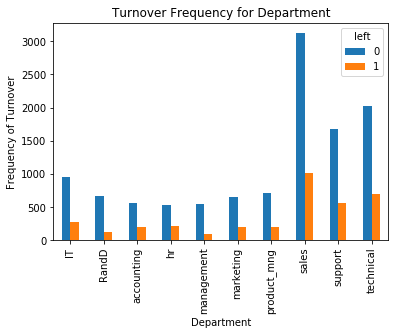

In [7]:
pd.crosstab(df.department,df.left).plot(kind='bar')
plt.title('Turnover Frequency for Department')
plt.xlabel('Department')
plt.ylabel('Frequency of Turnover')
plt.show()

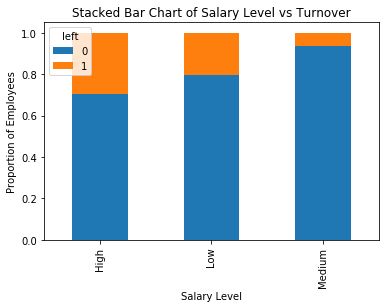

In [8]:
table=pd.crosstab(df.salary, df.left)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.xticks((0, 1, 2), ["High", "Low", "Medium"])
plt.title('Stacked Bar Chart of Salary Level vs Turnover')
plt.xlabel('Salary Level')
plt.ylabel('Proportion of Employees')
plt.show()

In [9]:
# Create dummy variables for department feature
df = pd.get_dummies(df, columns=["department"], drop_first=True)

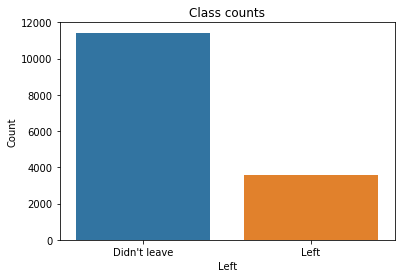

In [10]:
# Get the number of employees who left the company and those who didn’t
sns.countplot(df["left"])
plt.xticks((0, 1), ["Didn't leave", "Left"])
plt.xlabel("Left")
plt.ylabel("Count")
plt.title("Class counts")
plt.show()

As the graph shows, we have an imbalanced dataset. Moreover, class imbalance influences a learning algorithm during training by making the decision rule biased towards the majority class by implicitly learns a model that optimizes the predictions based on the majority class in the dataset. 

In [11]:
# Convert dataframe into numpy objects and split them into train and test sets: 80/20
X = df.loc[:, df.columns != "left"].values
y = df.loc[:, df.columns == "left"].values.flatten()

# Original minority class
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

# Upsample minority class
X_train_u, y_train_u = resample(X_train[y_train == 1],
                                y_train[y_train == 1],
                                replace=True,
                                n_samples=X_train[y_train == 0].shape[0],
                                random_state=1)
X_train_u = np.concatenate((X_train[y_train == 0], X_train_u))
y_train_u = np.concatenate((y_train[y_train == 0], y_train_u))

print "Original shape:", X_train.shape, y_train.shape 
print "Upsampled shape:", X_train_u.shape, y_train_u.shape 

Original shape: (11999L, 17L) (11999L,)
Upsampled shape: (18284L, 17L) (18284L,)


## Random Forest

In [12]:
# Build random forest classifier
methods_data = {"Original": (X_train, y_train),
                "Upsampled": (X_train_u, y_train_u)}

for method in methods_data.keys():
    pip_rf = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=500, class_weight="balanced", random_state=123))
    
    hyperparam_grid = {
        'randomforestclassifier__n_estimators': [10, 50, 100, 500],
        'randomforestclassifier__max_features': ["sqrt", "log2", 0.4, 0.5],
        'randomforestclassifier__min_samples_leaf': [1, 3, 5],
        'randomforestclassifier__criterion': ["gini", "entropy"]}
    
    gs_rf = GridSearchCV(pip_rf,
                         hyperparam_grid,
                         scoring='f1',
                         cv=10,
                         n_jobs=-1)
    
    gs_rf.fit(methods_data[method][0], methods_data[method][1])

    print 'The best hyperparameters for {} data:'.format(method)
    for hyperparam in gs_rf.best_params_.keys():
        print hyperparam[hyperparam.find('__') + 2:], ':', gs_rf.best_params_[hyperparam]   
    
    print 'Best 10-folds CV f1-score: {:.2f}%.'.format(gs_rf.best_score_ * 100)
    filename = 'random_forest_model_{:.2f}.sav'.format(gs_rf.best_score_ * 100)
    joblib.dump(gs_rf, filename)
    print 

The best hyperparameters for Upsampled data:
min_samples_leaf : 1
n_estimators : 50
criterion : entropy
max_features : 0.4
Best 10-folds CV f1-score: 99.80%.

The best hyperparameters for Original data:
min_samples_leaf : 1
n_estimators : 500
criterion : gini
max_features : 0.5
Best 10-folds CV f1-score: 98.19%.



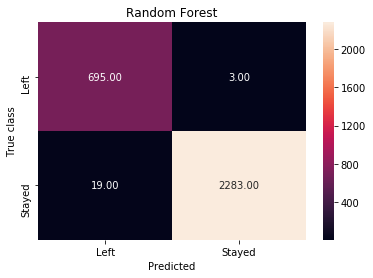

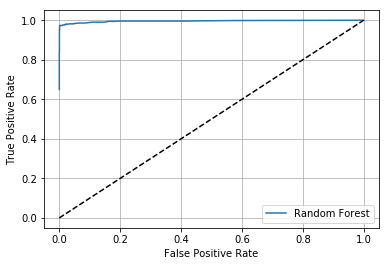

In [13]:
print_matrix(gs_rf, X_test, y_test, title='Random Forest')
print_roc(gs_rf, X_test, y_test,'Random Forest')

## Gradient Boosting Trees

In [14]:
# Build Gradient Boosting classifier
pip_gb = make_pipeline(StandardScaler(), GradientBoostingClassifier(loss='deviance', random_state=123))

hyperparam_grid = {'gradientboostingclassifier__max_features': ['log2', 0.5],
                   'gradientboostingclassifier__n_estimators': [100, 300, 500],
                   'gradientboostingclassifier__learning_rate': [0.001, 0.01, 0.1],
                   'gradientboostingclassifier__max_depth': [1, 2, 3]}

gs_gb = GridSearchCV(pip_gb,
                      param_grid=hyperparam_grid,
                      scoring='f1',
                      cv=10,
                      n_jobs=-1)

gs_gb.fit(X_train, y_train)

print 'The best hyperparameters:'
for hyperparam in gs_gb.best_params_.keys():
    print hyperparam[hyperparam.find('__') + 2:], ': ', gs_gb.best_params_[hyperparam]
print 'Best 10-folds CV f1-score: {:.2f}%.'.format(gs_gb.best_score_ * 100)
filename = 'gradient_boosting_model.sav'
joblib.dump(gs_gb, filename)

The best hyperparameters:
learning_rate :  0.1
max_features :  0.5
n_estimators :  500
max_depth :  3
Best 10-folds CV f1-score: 95.84%.


['gradient_boosting_model.sav']

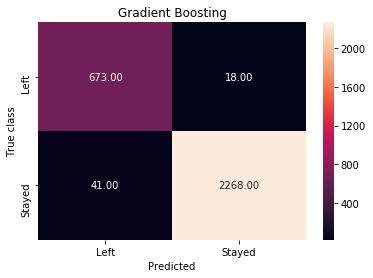

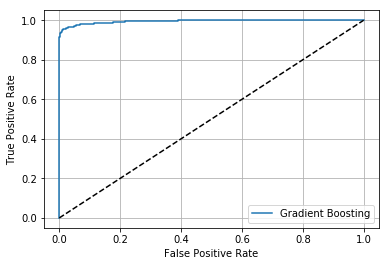

In [15]:
print_matrix(gs_gb, X_test, y_test, title='Gradient Boosting')
print_roc(gs_gb, X_test, y_test,'Gradient Boosting')

## K-Nearest Neighbors

In [16]:
# Build KNN classifier
pip_knn = make_pipeline(StandardScaler(), KNeighborsClassifier())
hyperparam_range = range(1, 20)
gs_knn = GridSearchCV(pip_knn,
                      param_grid={'kneighborsclassifier__n_neighbors': hyperparam_range,
                                  'kneighborsclassifier__weights': ['uniform', 'distance']},
                      scoring='f1',
                      cv=10,
                      n_jobs=-1)
gs_knn.fit(X_train, y_train)
print 'The best hyperparameters:'
print '-' * 25
for hyperparam in gs_knn.best_params_.keys():
    print hyperparam[hyperparam.find("__") + 2:], ':', gs_knn.best_params_[hyperparam] 
print 'Best 10-folds CV f1-score: {:.2f}%.'.format((gs_knn.best_score_) * 100)
filename = 'k_nearest_model.sav'
joblib.dump(gs_knn, filename)

The best hyperparameters:
-------------------------
n_neighbors : 1
weights : uniform
Best 10-folds CV f1-score: 92.87%.


['k_nearest_model.sav']

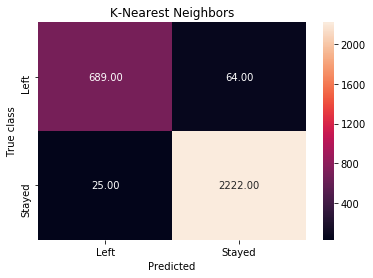

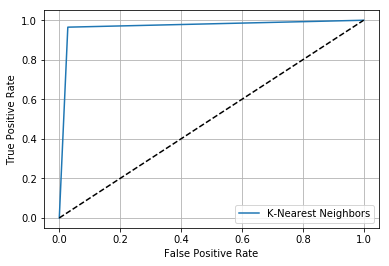

In [17]:
print_matrix(gs_knn, X_test, y_test, title='K-Nearest Neighbors')
print_roc(gs_knn, X_test, y_test,'K-Nearest Neighbors')

## Logistic Regression

In [18]:
# Build logistic model classifier
pip_logmod = make_pipeline(StandardScaler(),
                           LogisticRegression(class_weight='balanced'))
hyperparam_range = np.arange(0.5, 20.1, 0.5)
hyperparam_grid = {'logisticregression__penalty': ['l1', 'l2'],
                   'logisticregression__C':  hyperparam_range,
                   'logisticregression__fit_intercept': [True, False]
                  }
gs_logmodel = GridSearchCV(pip_logmod,
                           hyperparam_grid,
                           scoring='accuracy',
                           cv=2,
                           n_jobs=-1)
gs_logmodel.fit(X_train, y_train)
print 'The best hyperparameters:'
print '-' * 25
for hyperparam in gs_logmodel.best_params_.keys():
    print hyperparam[hyperparam.find("__") + 2:], ':', gs_logmodel.best_params_[hyperparam]
print 'Best 10-folds CV f1-score: {:.2f}%.'.format(gs_logmodel.best_score_ * 100)
filename = 'logistic_reg_model.sav'
joblib.dump(gs_logmodel, filename)

The best hyperparameters:
-------------------------
penalty : l1
fit_intercept : True
C : 0.5
Best 10-folds CV f1-score: 75.46%.


['logistic_reg_model.sav']

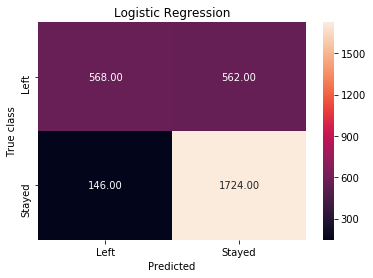

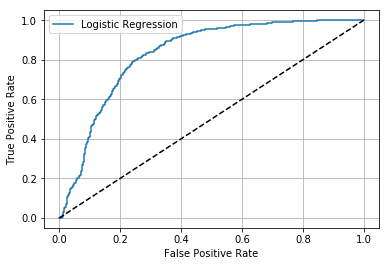

In [19]:
print_matrix(gs_logmodel, X_test, y_test, title='Logistic Regression')
print_roc(gs_logmodel, X_test, y_test,'Logistic Regression')

## Support Vector Machine (SVM)

In [20]:
# Build SVM classifier
clf_svc = make_pipeline(StandardScaler(),
                        SVC(C=0.01,
                            gamma=0.1,
                            kernel='poly',
                            degree=5,
                            coef0=10,
                            probability=True))
clf_svc.fit(X_train, y_train)
svc_cv_scores = cross_val_score(clf_svc,
                                X=X_train,
                                y=y_train,
                                scoring='f1',
                                cv=10,
                                n_jobs=-1)
# Print CV
print 'The 10-folds CV f1-score is: {:.2f}%'.format(np.mean(svc_cv_scores) * 100)
filename = 'svm_model.sav'
joblib.dump(clf_svc, filename)

The 10-folds CV f1-score is: 92.18%


['svm_model.sav']

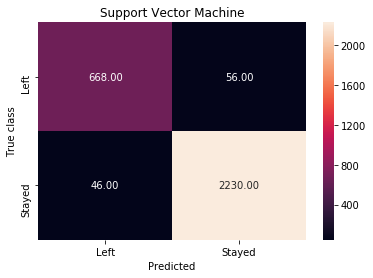

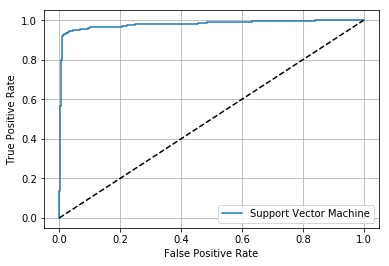

In [21]:
print_matrix(clf_svc, X_test, y_test, title='Support Vector Machine')
print_roc(clf_svc, X_test, y_test,'Support Vector Machine')

## Conclusion

Now we'll create a roc curve. The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible.

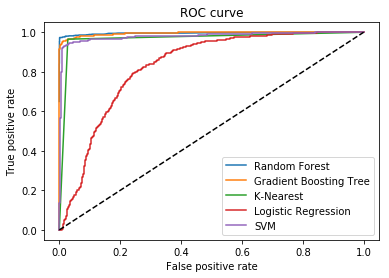

In [22]:
# Create roc curve
y_pred_rf = gs_rf.predict_proba(X_test)[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf)
plt.plot(fpr_rf_lm, tpr_rf_lm, label='Random Forest')

y_pred_gb = gs_gb.predict_proba(X_test)[:, 1]
fpr_gb_lm, tpr_gb_lm, _ = roc_curve(y_test, y_pred_gb)
plt.plot(fpr_gb_lm, tpr_gb_lm, label='Gradient Boosting Tree')

y_pred_knn = gs_knn.predict_proba(X_test)[:, 1]
fpr_knn_lm, tpr_knn_lm, _ = roc_curve(y_test, y_pred_knn)
plt.plot(fpr_knn_lm, tpr_knn_lm, label='K-Nearest')

y_pred_logmodel = gs_logmodel.predict_proba(X_test)[:, 1]
fpr_logmodel_lm, tpr_logmodel_lm, _ = roc_curve(y_test, y_pred_logmodel)
plt.plot(fpr_logmodel_lm, tpr_logmodel_lm, label='Logistic Regression')

y_pred_scv = clf_svc.predict_proba(X_test)[:, 1]
fpr_scv_lm, tpr_scv_lm, _ = roc_curve(y_test, y_pred_scv)
plt.plot(fpr_scv_lm, tpr_scv_lm, label='SVM')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.legend()
plt.show()

## Feature Importance

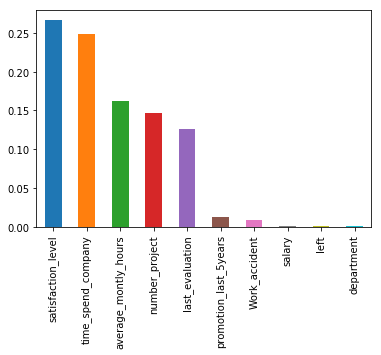

In [23]:
filename = 'random_forest_model_99.80.sav'
best_model = joblib.load(filename)

features = best_model.best_estimator_.steps[1][1].feature_importances_

imp_features = pd.Series(data=features[:10], index=dFrame.columns)
imp_features.sort_values(ascending=False, inplace=True)
imp_features.plot(kind='bar')
plt.show()

In [24]:
y_pred = best_model.predict_proba(X)[:, 1]

dFrame['Prediction'] = y_pred
dFrame.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary,Prediction
0,0.38,0.53,2,157,3,0,1,0,sales,low,1.0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,1.0
2,0.11,0.88,7,272,4,0,1,0,sales,medium,1.0
3,0.72,0.87,5,223,5,0,1,0,sales,low,1.0
4,0.37,0.52,2,159,3,0,1,0,sales,low,1.0


## Deployment of Model

In [25]:
from sklearn.externals import joblib
import numpy
ilename = 'random_forest_model_99.80.sav'
best_model = joblib.load(filename)

submit = Button(description='Predict Now!')

form_item = [
    FloatSlider(min=0., max =1., step= 0.005, value = 0., description='satisfaction_level'),
    FloatSlider(min=0., max =1., step= 0.005, value = 0., description='last_evaluation'),
    IntSlider(min=0, max=10, description='number_project'),
    IntSlider(min=80, max=400, description='average_montly_hours'),
    IntSlider(min=0, max=15, description='time_spend_company'),
    IntSlider(min=0, max=1, description='Work_accident'),
    IntSlider(min=0, max=1, description='promotion_last_5years'),
    Dropdown(options=['sales', 'technical', 'support', 'IT', 'product_mng', 'marketing', 'RandD', 
                      'accounting', 'hr', 'management'], description='department'),
    Dropdown(options=['High', 'Medium', 'Low'], description='salary'),
]

def switch_salary(label):
    switcher = {
        'High':2,
        'Medium':1,
        'Low':0
    }
    return switcher.get(label, 'Invalid')

def switch_department(label):
    switcher = {
        'sales':[0,0,0,0,0,0,1,0,0],
        'technical':[0,0,0,0,0,0,0,0,1],
        'support':[0,0,0,0,0,0,0,1,0],
        'IT':[0,0,0,0,0,0,0,0,0],
        'product_mng':[0,0,0,0,0,1,0,0,0],
        'marketing':[0,0,0,0,1,0,0,0,0],
        'RandD':[1,0,0,0,0,0,0,0,0],
        'accounting':[0,1,0,0,0,0,0,0,0],
        'hr':[0,0,1,0,0,0,0,0,0],
        'management':[0,0,0,1,0,0,0,0,0]
    }
    return switcher.get(label, 'Invalid')

def on_button_clicked(b):
    emp_row = []
    for widget in form_item:
        value = widget.value
        if widget.description == 'salary':
            value = switch_salary(value)
        emp_row.append(value)
    department = emp_row.pop(7)
    for i in switch_department(department):
        emp_row.append(i)
    y_pred = best_model.predict_proba(numpy.array(emp_row).reshape(1, -1))[:, 1]
    print '{:.2f} is the Probability the following employee will leave'.format(float(y_pred))

form = Box(form_item, layout=Layout(flex_flow='column'))
submit.on_click(on_button_clicked)

In [26]:
display(form, submit)

Qm94KGNoaWxkcmVuPShGbG9hdFNsaWRlcih2YWx1ZT0wLjAsIGRlc2NyaXB0aW9uPXUnc2F0aXNmYWN0aW9uX2xldmVsJywgbWF4PTEuMCwgc3RlcD0wLjAwNSksIEZsb2F0U2xpZGVyKHZhbHXigKY=


Button(description=u'Predict Now!', style=ButtonStyle())